<a href="https://colab.research.google.com/github/Sooryakiran/CS6886_SysDL/blob/master/assignment_3/Submission/Step%201/step_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1
======
Build a CNN on pytorch to train on the FMNIST data


### Import all the necessary libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### Define the Hyperparameters

In [0]:
BATCH_SIZE    = 32
EPOCHS        = 5
LEARNING_RATE = 0.001
MOMENTUM      = 0.9

### Define important functions and objects

In [0]:
class NormalizeTransform:
    """
    A torch transform class that normalises the dataset

    """
    
    def __init__(self, mean = 0.5, var = 0.5):
        """
        The class constructor

        @param mean : mean of the output dataset
        @param var  : variance of the output datset

        """

        self.mean = mean
        self.var  = var
    
    def __call__(self, x):
        """
        This function is called when the object is called.

        @param x : input datset
        @returns : normalized dataset

        """

        return (x-self.mean)/(self.var)


def imshow(image):
    """
    A function to print images of size 28x28 from the dataset

    @param image: input torch tensor representing the image

    """

    npimg = image.numpy()
    plt.imshow(np.resize(npimg, (28, 28)), cmap = 'gray')
    plt.show()


class ConvNet(nn.Module):
    """
    The network is defined as a torch module.

    """

    def __init__(self):
        """
        The class constructor.

        """

        super(ConvNet, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = 16,  kernel_size= 3)
        self.conv_2 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3)
        self.fc_1   = nn.Linear(16*24*24, 100)
        self.fc_2   = nn.Linear(100, 10)

    def forward(self, x):
        """
        The forward pass of the network.

        Layer 1: Convolution 3x3 16 channels with relu
        Layer 2: Convolution 3x3 16 channels with relu
        Layer 3: Fully connected 100 neurons with relu
        Layer 4: Output fully connected layer 10 neurons without activation 

        @param x : Input tensor of size (BATCH_SIZE, 1, 28, 28)
        @return  : Network output tensor of size (BATCH_SIZE, 10)

        """
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = x.view(-1, 16*24*24)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

def init_params(layer):
    """
    A function to initialize the network parameters. The weights are initialized
    with Xavier initialization. The biases are initialized with zeros.

    Usage:
        net.apply(init_params)
        where net is an nn.Module or nn.Seqential
    
    @param layer : each layers of the nn.Module/nn.Sequential

    """

    if type(layer) == nn.Linear:
        torch.nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0.0)

    elif type(layer) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0.0)


def accuracy(pred, target):
    """
    A function to calculate accuracy of a prediction.

    @param pred   : Network predictions tensor of size (BATCH_SIZE, num outputs)
    @param target : Target labels of size (BATCh_SIZE)

    Note: @param target is NOT onehot encoded.

    @return       : accuracy of the prediction.

    """

    preds    = torch.argmax(pred, dim = -1).detach().numpy()
    target   = target.detach().numpy()
    corrects = np.mean(np.asarray([preds[i] == target[i] for i in range(preds.shape[0])]))
    return corrects

def test(network, test_loader, criterion, accuracy_fn):
    """
    This function evaluates a model on the test dataset.

    @param network     : Neural network model
    @param test_loader : The dataloader object for the test dataset
    @param criterion   : The loss function
    @param accuracy_fn : The accuracy function

    @return test_loss, test_accuracy 

    """

    loss     = 0.0
    accuracy = 0.0
    batches  = 0

    for i, data in enumerate(test_loader):
        inputs, labels = data
        outputs        = net(inputs)

        loss     += criterion(outputs, labels)
        accuracy += accuracy_fn(outputs, labels)
        batches   = i + 1
    
    return (loss/batches).item(), (accuracy/batches).item()

### Define the dataloaders

In [0]:
transform = transforms.Compose([transforms.ToTensor(), NormalizeTransform()])

train_dataset = torchvision.datasets.FashionMNIST(train = True,
                                  root = '.',
                                  download = True,
                                  transform = transform)

test_dataset = torchvision.datasets.FashionMNIST(train = False,
                                  root = '.',
                                  download = True, 
                                  transform = transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)

### Print sample images

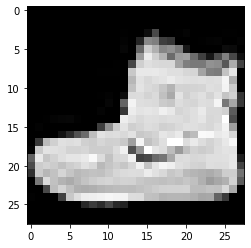

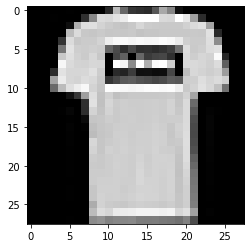

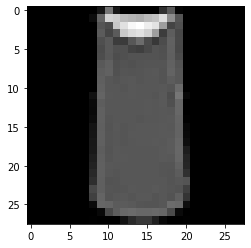

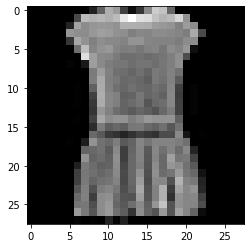

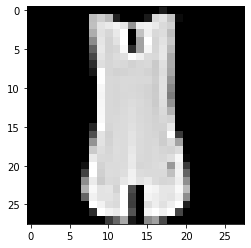

In [0]:
for i in range(5):
    img, _ = train_dataset[i]
    imshow(img)

### Instantiate the network, loss function and the optimizer

In [0]:
net = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = LEARNING_RATE, momentum = MOMENTUM)

Train and save the model

In [0]:
net.apply(init_params)

losses = []
accuracies = []
t_losses = []
t_accuracies = []
for epoch in range(EPOCHS):
    
    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy(outputs, labels)
        PRINT_EVERY = 128
        if i % PRINT_EVERY == PRINT_EVERY - 1:    
            print('[EPOCH: %d, BATCH: %5d]\t Loss: %.3f\t Accuracy: %.3f %% ' %
                  (epoch + 1, i + 1, running_loss / PRINT_EVERY, running_accuracy*100 / PRINT_EVERY))
            
            t_loss, t_acc = test(net, test_dataloader, criterion, accuracy)
            print("Test Loss: %f\t Test Accuracy: %f %%" %(t_loss, t_acc*100))

            losses.append(running_loss / PRINT_EVERY)
            accuracies.append(running_accuracy*100 / PRINT_EVERY)
            t_losses.append(t_loss)
            t_accuracies.append(t_acc*100)
            running_accuracy = 0.0
            running_loss = 0.0

torch.save(net, "model.pth")

[EPOCH: 1, BATCH:   128]	 Loss: 1.096	 Accuracy: 61.816 % 
Test Loss: 0.832038	 Test Accuracy: 70.766773 %
[EPOCH: 1, BATCH:   256]	 Loss: 0.681	 Accuracy: 74.658 % 
Test Loss: 0.758827	 Test Accuracy: 70.656949 %
[EPOCH: 1, BATCH:   384]	 Loss: 0.624	 Accuracy: 77.441 % 
Test Loss: 0.588087	 Test Accuracy: 78.674121 %
[EPOCH: 1, BATCH:   512]	 Loss: 0.559	 Accuracy: 79.517 % 
Test Loss: 0.598083	 Test Accuracy: 77.795527 %
[EPOCH: 1, BATCH:   640]	 Loss: 0.565	 Accuracy: 79.468 % 
Test Loss: 0.529173	 Test Accuracy: 80.920527 %
[EPOCH: 1, BATCH:   768]	 Loss: 0.527	 Accuracy: 80.127 % 
Test Loss: 0.549237	 Test Accuracy: 79.602636 %
[EPOCH: 1, BATCH:   896]	 Loss: 0.492	 Accuracy: 82.104 % 
Test Loss: 0.531846	 Test Accuracy: 80.730831 %
[EPOCH: 1, BATCH:  1024]	 Loss: 0.512	 Accuracy: 81.714 % 
Test Loss: 0.501559	 Test Accuracy: 82.218450 %
[EPOCH: 1, BATCH:  1152]	 Loss: 0.494	 Accuracy: 82.373 % 
Test Loss: 0.478196	 Test Accuracy: 82.458067 %
[EPOCH: 1, BATCH:  1280]	 Loss: 0.480

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
np.save("Losses.npy", np.asarray(losses))
np.save("Accuracies.npy", np.asarray(accuracies))
np.save("TestLosses.npy", np.asarray(t_losses))
np.save("TestAccuracies.npy", np.asarray(t_accuracies))

### If resuming from here download the .npy file from here

In [0]:
!wget https://github.com/Sooryakiran/CS6886_SysDL/raw/master/assignment_3/Step%201/Data/Accuracies.npy --no-verbose
!wget https://github.com/Sooryakiran/CS6886_SysDL/raw/master/assignment_3/Step%201/Data/Losses.npy --no-verbose
!wget https://github.com/Sooryakiran/CS6886_SysDL/raw/master/assignment_3/Step%201/Data/TestAccuracies.npy --no-verbose
!wget https://github.com/Sooryakiran/CS6886_SysDL/raw/master/assignment_3/Step%201/Data/TestLosses.npy --no-verbose

2020-05-04 16:41:47 URL:https://raw.githubusercontent.com/Sooryakiran/CS6886_SysDL/master/assignment_3/Step%201/Data/Accuracies.npy [688/688] -> "Accuracies.npy.1" [1]
2020-05-04 16:41:50 URL:https://raw.githubusercontent.com/Sooryakiran/CS6886_SysDL/master/assignment_3/Step%201/Data/Losses.npy [688/688] -> "Losses.npy" [1]
2020-05-04 16:41:53 URL:https://raw.githubusercontent.com/Sooryakiran/CS6886_SysDL/master/assignment_3/Step%201/Data/TestAccuracies.npy [688/688] -> "TestAccuracies.npy" [1]
2020-05-04 16:41:55 URL:https://raw.githubusercontent.com/Sooryakiran/CS6886_SysDL/master/assignment_3/Step%201/Data/TestLosses.npy [688/688] -> "TestLosses.npy" [1]
core  full  mqueue  ptmx  random  stderr  stdout  urandom
fd    fuse  null    pts   shm	  stdin   tty	  zero


In [0]:
losses = np.load("Losses.npy")
accuracies = np.load("Accuracies.npy")
t_losses = np.load("TestLosses.npy")
t_accuracies = np.load("TestAccuracies.npy")
PRINT_EVERY = 128

### Plot charts

In [0]:
num_batches = np.arange(len(losses)) * PRINT_EVERY

mpl.style.use('seaborn')
fig, ax = plt.subplots()
ax.set_title('Losses', color='C0')
ax.plot(num_batches, losses, 'C2', label = "Train Loss" )
ax.plot(num_batches, t_losses, 'C1', label = "Test Loss")
plt.xlabel("Batches")
plt.ylabel("Loss")
ax.legend()

fig, bx = plt.subplots()
bx.set_title('Accuracies', color='C0')
bx.plot(num_batches, accuracies, 'C2', label = "Train Accuracy" )
bx.plot(num_batches, t_accuracies, 'C1', label = "Test Accuracy")
plt.ylim(50, 100)  
plt.xlabel("Batches")
plt.ylabel("Accuracy in %")
bx.legend()

### Data preparation for Google Facets

Load the saved model and run on the test dataset. Log the outputs into a list.

In [0]:
"""
Skip if you already have the model saved after training above. Run only if resuming after training.

"""

!wget https://github.com/Sooryakiran/CS6886_SysDL/raw/master/assignment_3/Step%201/model.pth --no-verbose

2020-05-04 16:44:00 URL:https://raw.githubusercontent.com/Sooryakiran/CS6886_SysDL/master/assignment_3/Step%201/model.pth [3712675/3712675] -> "model.pth.1" [1]


In [0]:
model = ConvNet()
model = torch.load("model.pth")
model.eval()

test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)

labels = []
predictions = []
for i, data in enumerate(test_dataloader):
    x, y = data
    y = y.numpy()
    labels += list(y)

    y_ = torch.argmax(model(x), dim = -1).detach().numpy()
    predictions += list(y_)

#### Define the class names

In [0]:
classes = ["T-shirt/top",\
           "Trouser",\
           "Pullover",\
           "Dress",\
           "Coat",\
           "Sandal",\
           "Shirt",\
           "Sneaker",\
           "Bag",\
           "Ankle boot"]

#### Save the test predictions into a CSV file

In [0]:
!rm test_performance.csv
fp = open("test_performance.csv", 'w')
fp.seek(0, 0)
fp.write("True,Predicted\n")
for i in range(10000):
    string = classes[labels[i]] + "," + classes[predictions[i]] + "\n"
    fp.write(string)
fp.flush()
fp.close()